In [17]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from code_utils.read_ipcc_bib import read_bib_wg
from code_utils.clean_doi import get_doi_cleaned
from code_utils.enriching_data import get_countries
from code_utils.utils import aplatir

Read IPCC references in .bib files

In [ ]:
wgs={'1':{'wg1':[], 'dataframes_1':{}, 'listdir1':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG1")},
     '2':{'wg2':[], 'wg2_update':[], 'dataframes_2':{}, 'listdir2':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG2")},
     '2_CROSS':{'wg2_CROSS':[], 'wg2_CROSS_update':[], 'dataframes_2_CROSS':{}, 'listdir2_CROSS':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG2_CROSS")},
     '3':{'wg1':[], 'dataframes_3':{}, 'listdir3':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG3")}}

In [ ]:
for k in ['1','2','2_CROSS','3']:
    wgs[k][f'df_{k}'] = read_bib_wg(wgs,k,verbose=True)
    print(wgs[k][f'wg{k}_update'])
    #wgs[k][f'df_{k}'].to_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_wg{k}.jsonl', orient='records', lines=True)

Read and clean the data from 'structured_data' folder

In [2]:
data_all={}

In [4]:
for k in ['1','2','2_CROSS','3']:
   data_all[f'df_wg{k}']=pd.read_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_wg{k}.jsonl', lines= True)

In [5]:
#all data 
df_ipcc=pd.concat(list(data_all.values()), ignore_index=True)

In [6]:
df_ipcc['doi']=df_ipcc.loc[:,'doi'].apply(lambda x: get_doi_cleaned(x))

Enriching data through OpenAlex API integration

In [7]:
df_ipcc['freq']=1
df_ipcc.loc[:,'doi']=df_ipcc.loc[:,'doi'].apply(lambda x: None if str(x)[:4]=='http' else x)
df_unique_doi=df_ipcc.groupby(by='doi', dropna=True).agg({'wg': lambda x: list(x),'chap': lambda x: list(x), 'freq': 'sum'})

In [ ]:
#get data_OpenAlex from the API (6h)
"""
df_unique_doi.apply(lambda row: get_open_alex_data(json_OA,row['doi']), axis= 1)
pd.DataFrame(json_OA).to_json(path+'data_OpenAlex.json', orient='records') 
"""

In [8]:
#get data_OpenAlex from the file
data_OpenAlex_all=pd.read_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_OpenAlex.json')

In [13]:
countries_list = []
for i,row in df_unique_doi.reset_index().iterrows():
    countries=get_countries(data_OpenAlex_all,row)
    countries_list.append(countries)
data_OpenAlex_all['countries'] = countries_list

Visualization 

In [14]:
data_OpenAlex=data_OpenAlex_all[['doi','countries']]

In [15]:
df_ipcc=pd.merge(df_ipcc, data_OpenAlex, on='doi', how='left')
df_ipcc.loc[:,'countries']=df_ipcc.loc[:,'countries'].apply(lambda x: str(x).replace('nan','None').replace('[]','None').replace('[None]','None') if ((str(x)=='nan')|(str(x)=='[None]')|((str(x)=='[]'))) else x )
df_ipcc.loc[:,'countries']=df_ipcc.loc[:,'countries'].apply(lambda x: ['None'] if x=='None' else x)

In [27]:
data_counts = pd.Series(aplatir(list(df_ipcc['countries']))).value_counts().drop('None')

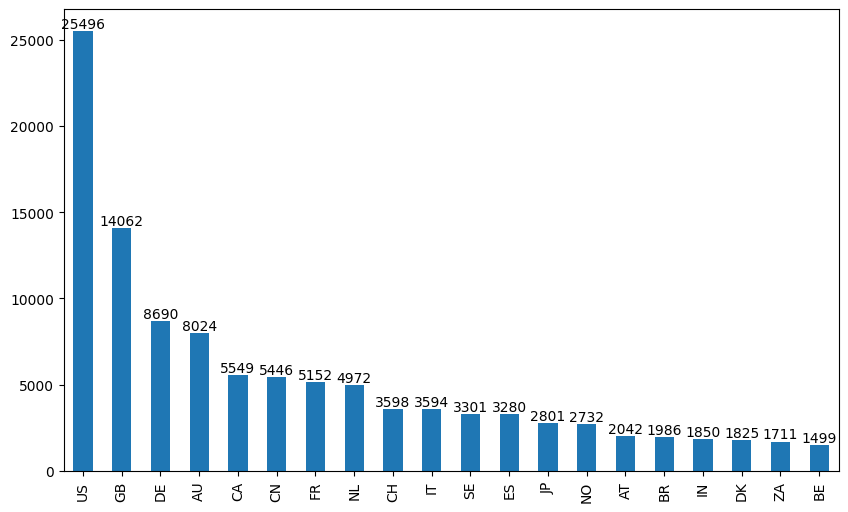

In [28]:
plt.figure(figsize=(10, 6))
data_counts[:20].plot(kind='bar')
ax = data_counts[:20].plot(kind='bar')
for i, v in enumerate(data_counts[:20]):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()